# SciPy Minimize: Multidimensional Optimization

<hr>
<b> Table of Contents</b>

* [Function Form](#functions)
* [Output Object](#output)
* [`args` and Function Parameters](#args)
* [Routine Choice](#routine_choice)
* [Routine Comparison](#routine_comparison)
* [Gradients](#gradients)
* [Hessians](#hessians)
* [Bounds and Constraints](#bounds_constraints)
    * [Bounds](#bounds)
    * [Linear Constraints for `trust-constr`](#linear_trustconstr)
    * [Non-linear Constraints for `trust-constr`](#nonlinear_trustconstr)
    * [Constraints in `SLSQP`](#constraint_SLSQP)
* [Conditioning](#conditioning)
    
<hr>

The `minimize` routine in the `scipy.optimize` module provides multidimensional optimization functionality. The function can call to a [variety of different algorithms](#routine_comparison) behind the scenes depending on the specifics of the problem.

In [5]:
# Importing the packages for the example
#
import numpy as np
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

<div id="functions" />

## Function Form
<hr>

The most important input to `minimize` is the <b>objective function</b> of the form:
$$
f: \mathbb{R}^d \rightarrow \mathbb{R}
$$
The function `f` takes inputs from a space of $d$ dimensional real numbers, like a vector $(x_0, x_1, ..., x_{d-1} )$, and maps them to a scalar. Then we try to find the smallest value for that scalar.

If you want to find a maximum instead, input `-f` to `minimize` instead of `f`, and the algorithm will find `f`'s maximum.

For this tutorial, we use the example function:
$$
f(\vec{x}) = x_0^2 + x_1^2 + x_0 x_1
$$

See [Test_Functions](./Test_Functions.ipynb) for functions that test certain aspects of minimization routines.

In [6]:
# Simplest test function
f = lambda x : x[0]**2 + x[1]**2 + x[0]*x[1]

### The Simplest Call

At the most basic, all you need to call minimize is:
* The objective function
* A starting point

In [7]:
starting_point=[1,1]

result=optimize.minimize(f,starting_point)
print(result)

      fun: 1.5869182200826406e-16
 hess_inv: array([[ 0.66666667, -0.33333333],
       [-0.33333333,  0.66666667]])
      jac: array([-6.91799246e-09, -6.91799246e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-7.27305122e-09, -7.27305122e-09])


Let's look at the function and the end result we just got.

The function chosen for the tutorial is a simple single parabolic bowl without any tricky features to watch out for, but this won't always be true for more complicated functions.

Text(0, 0.5, 'x[1]')

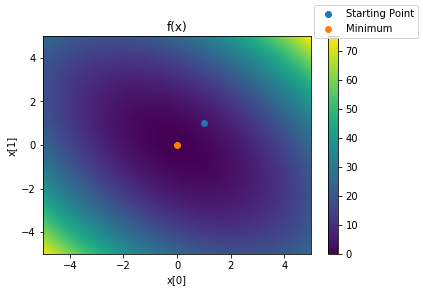

In [8]:
# Coordinates for plotting
x0 = np.arange(-5,5,.01)
x1 = np.arange(-5,5,.01)
# creating 2D array
x0_a, x1_a = np.meshgrid(x0,x1)

# plotting our test functions
fig, ax = plt.subplots()
pos = ax.pcolormesh(x0_a,x1_a,f([x0_a,x1_a]) )
ax.scatter(starting_point[0],starting_point[1],label='Starting Point')
ax.scatter(result.x[0],result.x[1],label='Minimum')

# labeling and measuring necessities
fig.legend()
fig.colorbar(pos,ax=ax)
ax.set_title('f(x)')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')

<div id="output" />

## Output Object
<hr>

Minimize outputs a custom object, `OptimizeResult`, which is based on a Python dictionary.  

Though it has some standard outputs, each method can return different information.  

Availible data can be accessed by

In [5]:
result.keys()

dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit'])

And each attribute can be accessed as:

In [6]:
result.x # the minimum

array([-7.27305122e-09, -7.27305122e-09])

<div id="args" />

## `args` and function parameters
<hr>

For a function with parameters and extra variables, the `args` parameter passes that variable to the function.

For example, if we add a parameter `a` that shifts the location of the minimum in the `x[1]` direction:

In [7]:
# Test function that uses a parameter a
f_parameter = lambda x , a: x[0]**2 + (x[1]-a)**2 + x[0]*(x[1]-a)

Then then we can pass any valid variable to to `args` at evaluation time:

In [8]:
result_parameter2 = optimize.minimize(f_parameter,[1,1],args=(2))
result_parameter3 = optimize.minimize(f_parameter,[1,1],args=(3))
print("Minimum Location a=2: ",result_parameter2.x)
print("Minimum Location a=3: ",result_parameter3.x)

Minimum Location a=2:  [-6.46465798e-09  2.00000000e+00]
Minimum Location a=3:  [-1.24749874e-06  3.00000100e+00]


<div id="routine_choice" />

## Choosing a Routine
<hr>

You can choose a specific method by passing an argument to the `method=` flag, like Nelder-Method:

In [9]:
result_Nelder_Mead=optimize.minimize(f,starting_point,method='Nelder-Mead')
print(result_Nelder_Mead)

 final_simplex: (array([[ 2.93637382e-06, -1.76886206e-05],
       [-5.26241709e-05,  4.58888034e-05],
       [ 5.46892983e-07,  7.08686217e-05]]), array([2.69569189e-10, 2.46022541e-09, 5.06141818e-09]))
           fun: 2.695691885846764e-10
       message: 'Optimization terminated successfully.'
          nfev: 70
           nit: 38
        status: 0
       success: True
             x: array([ 2.93637382e-06, -1.76886206e-05])


Methods can use different information, like gradients, hessians, or constraints, and can return different information within the `OptimizeResult` object.  For an indepth discussion of the various methods, see [Routine Comparison](#routine-comparison).

<div id="gradients" />

## Gradients
<hr>

#### Intro

The <b>gradient</b>, also known as <b>jacobian</b>, of a scalar valued function $f$ is defined as:
$$
\nabla f = \begin{bmatrix}
\frac{\partial f(x)}{\partial x_0} & \frac{\partial f(x)}{\partial x_1} & \dots & \frac{\partial f(x) }{\partial x_d}  
\end{bmatrix}
$$
The gradient says in which direction the function is decreasing/ increasing the most.  Generally, by following that direction we can find the minimum.  We can also think about using the gradient to construct a local approximation of the function, and then finding the minimum of that local approximation.

The gradient also provides some sanity checks.  The the algorithm should be using the gradient, check if the result object provides a `jac` approximation at the end.  Also, local extrema or saddle points should have a gradient of $\vec{0}$.  If you are solving a bounded problem, and the gradient of the fucntion at the solution is not $\vec{0}$, then the bounds matter.

Derivatives can be supplied to CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, truct-ncg, trust-krylov, trust-exact, and trust-constr.

The gradient of our tutorial function evaluates to:
$$
\nabla \left( x_0^2 + x_1^2 + x_0 x_1 \right)= \begin{bmatrix}
2 x_0 + x_1 & 2 x_1 + x_0
\end{bmatrix}
$$

#### Usage

First write a function to return a numpy array, like:

In [10]:
def df (x):
    df_dx0 = 2*x[0] + x[1]
    df_dx1 = 2*x[1] + x[0]
    return np.array([df_dx0, df_dx1])

To see how this might be useful, let's look at a quiver plot of the gradient.

The negative of the gradient seems to point more or less right toward the minimum.

Text(0.5, 1.0, 'The Gradient')

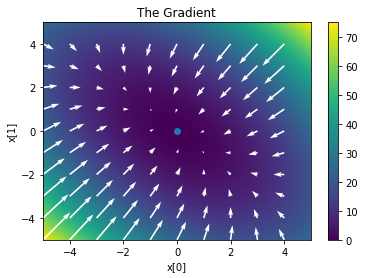

In [11]:
# Setting up the data
x0_quiver=np.arange(-5,5,1)
x1_quiver=np.arange(-5,5,1)
x0_a_quiver, x1_a_quiver = np.meshgrid(x0_quiver,x1_quiver)
df_quiver=df([x0_a_quiver,x1_a_quiver])

# Plotting the Data
fig, ax = plt.subplots()
pos = ax.pcolormesh(x0_a,x1_a,f([x0_a,x1_a]))
ax.quiver(x0_quiver,x1_quiver,-df_quiver[0,:,:],-df_quiver[1,:,:], color='white')
ax.scatter(result.x[0],result.x[1],label='Minimum')

# Labeling
fig.colorbar(pos,ax=ax)
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_title('The Gradient')

If we have the gradient/ jacobian, we can pass that to the solver via the `jac`, jacobian, flag:

In [12]:
result_jac = optimize.minimize(f,starting_point,jac=df)
print(result_jac.message,"\t",result_jac.jac)

Optimization terminated successfully. 	 [3.33066907e-16 3.33066907e-16]


We can also input both the function and it's derivative at the same time. This could be efficient if both repeat many of the same computations.

When `jac` flag recieves the Boolean `True`, `minimize` knows to look for the derivative with the function.  We also need to define a new function that returns a both a function and it's derivative at the time:

In [13]:
def f_jac_together (x):
    return f(x),df(x)

result_jac_together = optimize.minimize(f_jac_together,starting_point,jac=True)
print(result_jac_together.message,"\t",result_jac_together.jac)

Optimization terminated successfully. 	 [3.33066907e-16 3.33066907e-16]


Let's just double check our manual derivatives.  Maybe something went wrong with our algebra.  Luckily, `optimize` provides a rountine for this:

In [14]:
location=np.random.rand(2)
optimize.check_grad(f,df,location)

9.0781437089681e-09

By returning near zero, the rountine confirms that our manual gradient is basically identical to a finite derivative method at a random location.

If we don't provide a function for the derivative, the routines can use a finite approximation instead.  If a method requiring a derivative is specified, but no derivative is given, then a finite approximation is used. 

In [15]:
result_CG1=optimize.minimize(f,starting_point,method='CG')
print("Is there a jacobian? ",result_CG1.jac)

Is there a jacobian?  [2.13371764e-08 2.13371764e-08]


We could also specify `jac=False`.  

This doesn't mean don't use the jacobian.  It means don't use an analytical formula, but instead use a discrete numerical calculation for the jacobian:

In [16]:
result_CG2=optimize.minimize(f,starting_point,jac=False)
print("Is there a jacobian? ",result_CG2.jac)

Is there a jacobian?  [-6.91799246e-09 -6.91799246e-09]


We could also specify `2-point`, which is a specific method of discretely calculating the derivatives:

In [19]:
result_2point=optimize.minimize(f,[1,1],jac='2-point')
print("Is there a jacobian? ",result_2point.jac)

Is there a jacobian?  [-6.91799246e-09 -6.91799246e-09]


The optimize module also provides the function to look at this discrete calculation itself:

In [20]:
delta=np.array([1e-6,1e-6])

optimize.approx_fprime(starting_point,f, delta )

array([3.000001, 3.000001])

#### Only in `trust-constr`!!!!!
we have two other ways of discretely calculating the derivatives, `'3-point'` and `'cs'` in the method`trust-constr`.

`trust-constr` isn't the best method for this particular `f`, but we don't care about that here.

In [21]:
result_3point = optimize.minimize(f,starting_point,jac='3-point',method='trust-constr')
result_2point_tc = optimize.minimize(f,starting_point,jac='2-point',method='trust-constr')
result_cs = optimize.minimize(f,starting_point,jac='cs',method='trust-constr')
print(result_3point.message,"\t",result_2point_tc.message,"\t",result_cs.message)

`gtol` termination condition is satisfied. 	 `xtol` termination condition is satisfied. 	 `gtol` termination condition is satisfied.


/home/shaula/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


<div id="hessians" />

## Hessians
<hr>

Hessians can be supplied to:
* Newton-CG
* dogleg
* trust-ncg
* trust-krylov
* trust-exact
* trust-constr

Thes Hessian is defined as:
$$
H(\vec{x}) = \begin{bmatrix}
\frac{\partial^2 f(x)}{\partial x_0^2} & \frac{\partial^2 f(x)}{\partial x_0 \partial x_1} & \dots & \frac{\partial^2 f(x)}{\partial x_0 \partial x_d} \\
\frac{\partial^2 f(x)}{\partial x_1 \partial x_0} & \frac{\partial^2 f(x)}{\partial x_1^2 } & \dots & \frac{ \partial^2 f(x)}{\partial x_1 \partial x_d} \\
\dots & \dots & & \dots \\
\frac{\partial^2 f(x)}{\partial x_d \partial x_d} & \frac{\partial^2 f(x)}{\partial x_d \partial x_1} & \dots & \frac{\partial^2 f(x)}{\partial x_d^2}
\end{bmatrix}
$$

While the gradient provides $d$ more computations per iteration, these extra computations often pay off in terms of added efficiency.  The Hessian, though, adds $d^2$ extra computations per calculation for only quadratic better information.  This doesn't always pay off in terms of computational efficiency.


For our test function of:
$$
f(\vec{x}) = x_0^2 + x_1^2 + x_0 x_1
$$
the Hessian evaluates to:
$$
H(\vec{x}) = \begin{bmatrix}
2 & 1 \\
1 & 2 
\end{bmatrix}
$$
which we can write into a function:

In [22]:
d2f = lambda x: np.array([[2,1],[1,2]])

We can then send this function to `minimize` via the `hess` option.  We also need to specify a method that can take advantage of the hessian:

In [23]:
result_hess=optimize.minimize(f,starting_point,method='Newton-CG',jac=df,hess=d2f)

#### Positive Definite

`dogleg` requires the Hessian to be positive definite.

If a point is actually a minimum, the Hessian is positive difinite.  Implies convex.

For any vector $x$,
$$
x^T H x >0
$$

We can check this equation at our minimum using a randomly generated $x$:

In [24]:
x=np.random.rand(2)
x.dot(d2f(result.x).dot(x))>0

True

#### Hessian shortcut

Availible in Newton-CG, trust-ncg, trust-krylov, trust-constr

If the entire Hessian is too unwieldy to calculate, the Hessian times a vector $ \mathbf{H} \vec{p}$ can be used instead for certain methods like Newton- CG.

Given our known Hessian, we can analytically calculate this in our example as:
$$
H \vec{p} = \begin{bmatrix}
2 & 1 \\ 1 & 2 \\
\end{bmatrix} \begin{bmatrix}
p_0 \\ p_1 
\end{bmatrix}
= 
\begin{bmatrix}
2 p_0 + p_1 \\ p_0 + 2 p_1
\end{bmatrix}
$$

In [25]:
d2f_p = lambda x , p : np.array([ 2*p[0]+p[1] , p[0]+2*p[1] ])

In [28]:
result_hessp= optimize.minimize(f,starting_point,jac=df,method='Newton-CG',hessp=d2f_p)
print(result_hessp.message)

Optimization terminated successfully.


<div id="bounds_constraints" />

## Bounds and Constraints
<hr>



<div id="bounds" />

#### Bounds

Work on TNC, L-BFGS-B, trust-constr, SLSQP

For example, a hard box:
$$
n_{lower,0} < x_0<n_{upper,0} \qquad \qquad n_{lower,1} < x_1 < n_{upper,1}
$$

Let's plot what this looks like:

In [30]:
nb_lower0=1 # the lower bound on the 0th variable
nb_upper0=2 # the upper bound on the 0th variable

nb_lower1=3 # the lower bound on the 1st variable
nb_upper1=4 # the upper bound on the 1st variable

Text(0, 0.5, 'x[1]')

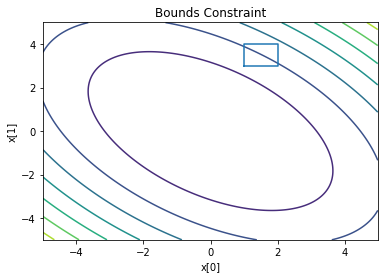

In [31]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.plot([nb_lower0,nb_lower0,nb_upper0,nb_upper0,nb_lower0],[nb_lower1,nb_upper1,nb_upper1,nb_lower1,nb_lower1],label='Bounds')

ax.set_title('Bounds Constraint')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')

In [32]:
# create bounds object array of lower limits then array of upper limits
bounds=optimize.Bounds([nb_lower0,nb_lower1],[nb_upper0,nb_upper1])
result_bounds=optimize.minimize(f,[1.5,1.5],bounds=bounds)
print(result_bounds)

      fun: 13.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.00000006, 6.99999987])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 1
   status: 0
  success: True
        x: array([1., 3.])


<div id="linear_trustconstr" />

### Linear constraints for `trust-constr`

Note: `trust-constr` requires gradient and hessian
Linear constraints take the general form:
$$
n_{lower} < \vec{A} \cdot \vec{x} < n_{upper}
$$

While I might think of a constraint in a form like this example:
$$
2 x_0 +3 <x_1
$$
as I can then graphically imagine "`x[1]` is restricted to be above this line".  But I can move it into a form that looks like the general form:
$$
-\infty < 2 x_0 - 1 x_1 < -3
$$

I will also use a second linear constraint, with a geometric form of 
$$
x_1 < \frac{1}{3} x_0
$$
and a constraint form of
$$
0 < x_0 + 3 x_1 < \infty
$$

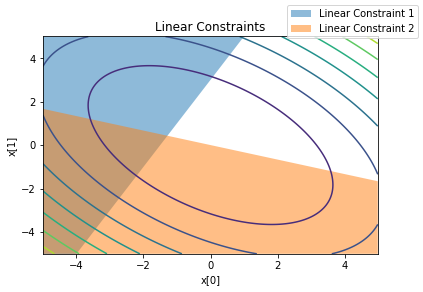

In [143]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.fill_between(x0,2*x0+3,5,alpha=0.5,label='Linear Constraint 1')
ax.fill_between(x0,-1/3*x0,-5,alpha=0.5,label='Linear Constraint 2')

ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_title('Linear Constraints')
fig.legend()

In [114]:
nl_lower1=-np.inf          # linear lower bound
nl_upper1=-3               # linear lower bound
A1=[-1,2]                  # linear vector

linear_constraint = optimize.LinearConstraint(A1,n_lower1,n_upper1)

We can input two constraints at the same time by combining each input in an array:

In [115]:
nl_lower2=0
nl_upper2=np.inf
A2=[-3,1]

linear_constraint2= optimize.LinearConstraint([A1,A2],[n_lower1,n_lower2],
                                             [n_upper1,n_upper2])

We then pass the linear constraint object to `minimize` via the `constraint` parameter:

In [145]:
result_linearconstraint=optimize.minimize(f,[2,0],
                    method='trust-constr',jac=df,hess=d2f,
                  constraints=linear_constraint)
print(result_linearconstraint.message)

`gtol` termination condition is satisfied.


<div id="nonlinear_trustconstr" />

### Non-linear Constraint in `trust-constr`
Nonlinear constraints objects fall into the form:
$$
n_{lower} < c(x) < n_{upper}
$$

Here, we use the concrete example:
$$
-\infty < x_0^2 +2 x_0 - x_1 < -1
$$
Where we could also write our constraint as
$$
(x_0 + 1)^2 < x_1
$$
We can graphically see what this example looks like:

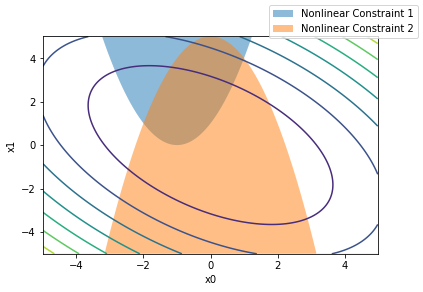

In [148]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.fill_between(x0,(x0+1)**2,5,alpha=0.5,label='Nonlinear Constraint 1')
ax.fill_between(x0,-x0**2+5,-5,alpha=0.5,label='Nonlinear Constraint 2')

ax.set_xlabel('x0')
ax.set_ylabel('x1')
fig.legend()

We create a nonlinear constraint object in much the same way that we created a linear constraint object.

In [118]:
nnl_lower1=-np.inf
nnl_upper1= -1

c1 = lambda x : x[0]**2 - 2* x[0] - x[1]

nonlinear_constraint=optimize.NonlinearConstraint(c1,n_lower1,n_upper1)

If we want to add two or more constraints to the same system, we use arrays to combine them into the same input

Let's add

$$
x_1 < -x_0^2+ 5
$$
$$
-5 < -x_0^2 - x_1 < \infty
$$

In [119]:
nnl_lower2=-5
nnl_upper2=np.inf

c2 = lambda x : -x[0]**2 - x[1]

nonlinear_constraint2=optimize.NonlinearConstraint([c1,c2],[n_lower1,n_lower2],[n_upper1,n_upper2])

Again just like a linear constraint, we pass this object to `constraint`:

In [120]:
result_nonlinearconstraint=optimize.minimize(f,[2,0],method='trust-constr',jac=df,hess=d2f,
                  constraints=nonlinear_constraint)
print(result_nonlinearconstraint.message)

`gtol` termination condition is satisfied.


In [123]:
result_2constraints=optimize.minimize(f,[2,0],method='trust-constr',jac=df,hess=d2f,
                  constraints=[linear_constraint,nonlinear_constraint])
print(result_2constraints.message)

The maximum number of function evaluations is exceeded.


Enforcing nonlinear constraints uses the gradient and hessian.  Just like for the general functions, the derivatives for the constraints can be provided and the method of calculation can be controlled.

<div id="constraint_SLSQP" />

### Constraints in SLSQP

In SLSQP (Sequential Least SQuares Programming), `minimize` has both inequality and equality constraints that can be defined via dictionaries. SLSQP can also accept the [bounds](#bounds) constraints discussed above.

An <b>inequality constraint</b> takes the form
$$
c(\vec{x}) \geq 0.
$$
For an constraint of the form
$$
c^{\prime}(\vec{x}) \leq 0
$$
simply multiply the function by $-1$ negative one.  

An <b>equality contraint</b> takes the form
$$
c(\vec{x}) = 0
$$
and effectively reduces the dimension of the problem by one.

In [27]:
c1 = lambda x : -(x[0]-1)**2 + x[1] 
c2 = lambda x : (x[0])**3 - x[1]

To visualize a constraint, I use `np.where` to generate data points where a condition holds.  
Here I will look at where the constraint functions `c1` and `c2` give the inequality condition to be true.

The border between true and false will be the equality constraint.

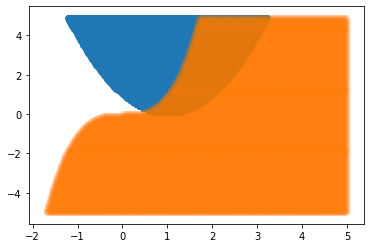

In [42]:
x0_a_constraint1 = np.where(c1([x0_a,x1_a])>0,x0_a,np.nan)
x1_a_constraint1 = np.where(c1([x0_a,x1_a])>0,x1_a,np.nan)

x0_a_constraint2 = np.where(c2([x0_a,x1_a])>0,x0_a,np.nan)
x1_a_constraint2 = np.where(c2([x0_a,x1_a])>0,x1_a,np.nan)

plt.scatter(x0_a_constraint1[0::10],x1_a_constraint1[0::10])
plt.scatter(x0_a_constraint2[0::10],x1_a_constraint2[0::10],alpha=0.05)

So how do we construct this dictionary?

We simply need to define the <b>type</b> and the <b>function</b> `fun`.  

For more than one constraint in the same dictionary, there must still be only one function that returns a numpy array.

In [27]:
# just one constraint
ineq_cons1 = {'type':'ineq',
            'fun': c1}

# having two constraints at once
ineq_cons2 = {'type':'ineq',
             'fun': lambda x : np.array([c1(x) , c2(x)]) }

For an inequality constraint, this looks like:

In [45]:
eq_cons = {'type':'eq',
            'fun':c1}

The jacobian of a constraint can also be included as 

In [46]:
d_c1 = lambda x : np.array([-2*x[0]+1,1])

ineq_cons1_jac = {'type' : 'ineq',
                 'fun' : c1,
                 'jac' : d_c1} 

After defining the dictionary, you can simply pass it to `minimize` through:

In [49]:
optimize.minimize(f,starting_point,method='SLSQP',constraints=ineq_cons1)

     fun: 0.4299286454813456
     jac: array([1.19392722, 1.06673736])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.44037793, 0.31317686])

<div id="routine_comparison" />

## Routine Comparison
<hr>

No method is a golden hammer, that works well on every problem.  Each has strengths or weakness, dealing with aspects of the posed problem.  

When choosing a method, consider for your problem:

* Computational intensity of one evaluation
* Number of dimensions
* Derivatives
    * Even differentiable?
    * Analytic gradient/ Hessian?
* Constraints
* How non-linear
* Convex/ concave

If the function doesn't have even a trustworthy numerical derivatives, the <b>Nelder-Mead</b> simplex algorithm can find a minimum without them.

Other generally methods fall into either the <b>Line Search</b> or <b>trust region</b> categories.

Right now, this is just a bunch of scribbled notes...

Nelder-Mead simplex method: Derivative free optimization

Gradient/ Line Methods: 
* Conjugate Gradient
* Newton-CG (zeros the gradient) good if cheap hessian


L-BFGS suitable for large numbers of variables
Quasi-Newton methods: Hessian approximated by recent evaluations

Constraints: 
* Constrained optimization by linear approximation COBYLA
* Sequential Quadratic Programming SLSQP
* trust-constr
* TNC? truncated newton algorithm
* L-BFGS-B


Hessian postivie definate?

What means to be large scale problem?

So we have newton-cg AND TNC, same thing, but TNC permits bounds



Derivatives can be supplied to:
* CG
* BFGS
* Newton-CG
* L-BFGS-B
* TNC
* SLSQP
* dogleg
* truct-ncg
* trust-krylov
* trust-exact
* trust-constr


Hessians can be supplied to:
* Newton-CG
* dogleg
* trust-ncg
* trust-krylov
* trust-exact
* trust-constr

<div id="#conditioning" />

## Conditioning
<hr>